# Analyzing the output of a polychrom simulation

Running example.py generates a few different output files, one with the starting conformation, one with the intial arguments, one with the appliced forces, one with the forcekit, and finally the blocks. Here, we ran 10 blocks, each of 100 timesteps each, and set the max data length to 5.

In [2]:
ls trajectory/

applied_forces_0.h5  blocks_5-9.h5                 initArgs_0.h5
blocks_0-4.h5        forcekit_polymer_chains_0.h5  starting_conformation_0.h5


In [1]:
import pandas as pd

In [20]:
#Here are the import statements sameer used in his notebook to analyze a simulation
import os
import importlib as imp
from collections import defaultdict
import h5py
import json
from copy import deepcopy
import multiprocessing as mp

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d, interp2d

import polychrom
from polychrom import polymer_analyses, contactmaps, polymerutils
from polychrom.hdf5_format import list_URIs, load_URI

#import nglutils as ngu
#import nglview as nv

In [3]:
%matplotlib notebook

## Reading data

list_URIs will list all of the files starting with `block` with one URI (universal resource identifier aka path) per conformation

In [6]:
trajs = list_URIs('trajectory')
print(trajs)

['trajectory/blocks_0-4.h5::0', 'trajectory/blocks_0-4.h5::1', 'trajectory/blocks_0-4.h5::2', 'trajectory/blocks_0-4.h5::3', 'trajectory/blocks_0-4.h5::4', 'trajectory/blocks_5-9.h5::5', 'trajectory/blocks_5-9.h5::6', 'trajectory/blocks_5-9.h5::7', 'trajectory/blocks_5-9.h5::8', 'trajectory/blocks_5-9.h5::9']


In [4]:
#TODO: figure out how to extract initial parameters from other h5 files

In [7]:
data = load_URI(trajs[0])

In [8]:
data

{'pos': array([[-0.47, -1.51, -0.37],
        [-0.45, -1.95,  0.55],
        [ 0.45, -2.32,  0.71],
        ...,
        [ 2.05, -1.76,  0.76],
        [ 1.21, -1.56,  0.26],
        [ 0.5 , -1.88, -0.22]], dtype=float32),
 'block': 0,
 'kineticEnergy': 1.8880411331282307,
 'potentialEnergy': 2.5845410077802025,
 'time': 6.356380507349968}

In [9]:
ls trajectory

applied_forces_0.h5  blocks_5-9.h5                 initArgs_0.h5
blocks_0-4.h5        forcekit_polymer_chains_0.h5  starting_conformation_0.h5


In [15]:
with h5py.File("trajectory/initArgs_0.h5", 'r') as f:
    N = f.attrs['N']
N

10000

In [1]:
ls simulations/test_integrator

applied_forces_0.h5  blocks_400-499.h5  blocks_900-999.h5
blocks_0-99.h5       blocks_500-599.h5  forcekit_polymer_chains_0.h5
blocks_100-199.h5    blocks_600-699.h5  initArgs_0.h5
blocks_200-299.h5    blocks_700-799.h5  starting_conformation_0.h5
blocks_300-399.h5    blocks_800-899.h5


In [6]:
ls /home/dkannan/simulations/

test_integrator/


## Computing P(s) scaling as a function of simulation time

In [83]:
from cooltools.lib import numutils
from pathlib import Path
from functools import partial

from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

basepath ='/home/dkannan/simulations/self-avoidance'

In [84]:
with h5py.File(Path(basepath)/"initArgs_0.h5", 'r') as f:
    N = f.attrs['N']
chains = np.arange(0, N+1, N)

T_steps = 1000
integrations_per_save = 100
T_blocks = T_steps

col_rate = 2.0
density = 0.224

In [85]:
bin_edges = numutils._logbins_numba(1, N, ratio=1.25, prepend_zero=True)
bin_edges

array([  0,   1,   2,   3,   4,   5,   7,   9,  11,  14,  18,  23,  30,
        38,  48,  62,  78, 100])

In [86]:
start = int(0.05*T_blocks)
end = T_blocks
block_ratio = 1.25
blocks = numutils._logbins_numba(start, end, ratio=block_ratio, prepend_zero=False)
cutoff_rad = 1.0
blocks

array([  50,   64,   82,  106,  136,  174,  224,  287,  368,  473,  607,
        779, 1000])

In [87]:
def process(uri, blocks, bin_edges, chains, cutoff=1.1):
    idx = int(uri.split('::')[-1])
    data = load_URI(uri)['pos']

    ser = {}
    chunk = np.searchsorted(blocks, idx, side='right')
    ser['chunk'] = [chunk]

    bins = None
    contacts = None
    for st, end in zip(chains[0:-1],chains[1:]):
        conf = data[st:end,:]
        x,y = polymer_analyses.contact_scaling(conf, bins0=bin_edges, cutoff=cutoff)
        if bins is None:
            bins = x
        if contacts is None:
            contacts = y
        else:
            contact = contacts + y

    ser['Ps'] = [(bins, contacts)]
    return pd.DataFrame(ser)


In [88]:
uris = list_URIs(f'{basepath}')
df = process(uris[-1], blocks, bin_edges, chains, cutoff=1.0)
np.array(df['Ps'])

array([([0.0, 1.0, 2.0, 3.0, 4.0, 5.477225575051661, 7.483314773547883, 9.486832980505138, 11.958260743101398, 15.427248620541512, 19.8997487421324, 25.826343140289914, 33.31666249791537, 42.261093218230876, 54.11099703387473, 69.0941386804988, 87.87491109526086], array([0.        , 0.38383838, 0.02040816, 0.01030928, 0.        ,
       0.01058201, 0.01081081, 0.00552486, 0.        , 0.00295858,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]))], dtype=object)

In [94]:
sim = 'test'
uris = list_URIs(f'{basepath}')
savepath = f'{basepath}/results'
Path(savepath).mkdir(exist_ok=True)
cutoff_rad = 5.0
savename = f'{sim}__logtime{str(start).zfill(5)}-{str(end).zfill(5)}-{block_ratio:.2f}__cutoff{cutoff_rad:.1f}.npy'
print(savename)

f = partial(process, blocks=blocks, bin_edges=bin_edges, chains=chains, cutoff=cutoff_rad)
with mp.Pool(20) as p:
    results = p.imap_unordered(f, uris, chunksize=5)
    df = polymer_analyses.streaming_ndarray_agg(results, 
                                                chunksize=5,
                                                ndarray_cols=['Ps'], 
                                                aggregate_cols=['chunk'], 
                                                add_count_col=True, divide_by_count=True
                                                )

result = []
for _, row in df.iterrows():
    arr = row['Ps']
    arr[1,0] = 1
    result.append(arr)

result = np.dstack(result)

np.save(f'{savepath}/{savename}', result)

test__logtime00050-01000-1.25__cutoff5.0.npy


In [92]:
ls /home/dkannan/simulations/self-avoidance/results


hotColdTest__logtime00050-01000-1.25__cutoff2.0.npy
test__logtime00050-01000-1.25__cutoff2.0.npy


## Plot P(s) scaling

<IPython.core.display.Javascript object>


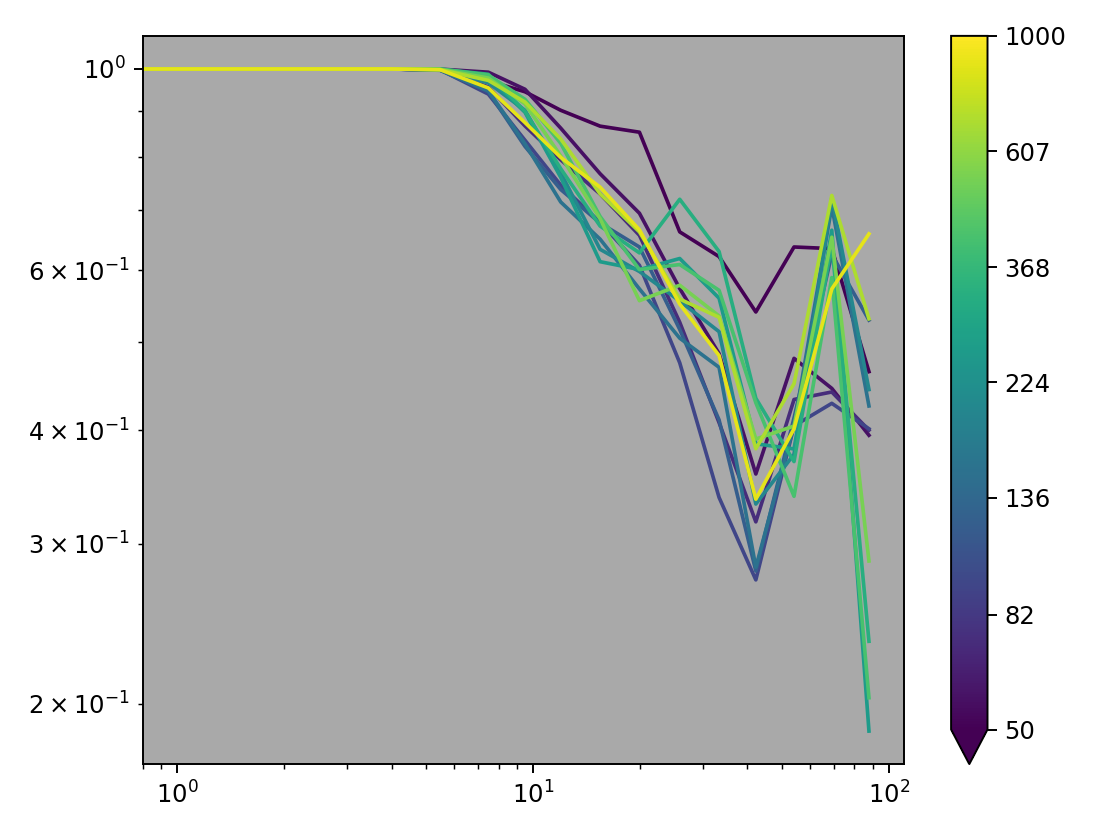

In [95]:
loadpath = savepath
cmap = plt.get_cmap('viridis')
crange = np.log10(blocks)
norm = mpl.colors.Normalize(vmin=crange.min(),vmax=crange.max())

fig, ax = plt.subplots()

filename = f'{sim}__logtime{str(start).zfill(5)}-{str(end).zfill(5)}-{block_ratio:.2f}__cutoff{cutoff_rad:.1f}.npy'

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_aspect('equal')
ax.set_facecolor('darkgray')
#ax.set_xlim([10**3,5*10**7])
#ax.set_ylim([5*10**-5, 10**0])

arr = np.load(f'{loadpath}/{filename}')
for k in range(arr.shape[-1]):
    Bst = 0 if not k else blocks[k-1]
    Bend = blocks[k]
    x = arr[0,:,k]
    y = arr[1,:,k]
    cval = np.log10((Bend+Bst)/2)
    ax.plot(x, y, color=cmap(norm(cval)))

#cax = fig.add_subplot(gs[:,-1])
slicing = slice(0,len(crange),2)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), extend='min', ticks=crange[slicing])
cbar.ax.set_yticklabels([x for x in np.ceil((10**crange[slicing])).astype(int)])
fig.tight_layout()

# Plot contact map

In [51]:
len(uris)

1000

In [96]:
mat = contactmaps.monomerResolutionContactMap(filenames=uris[-100:], cutoff=5.0)
mat = mat / len(uris[-100:])

<IPython.core.display.Javascript object>


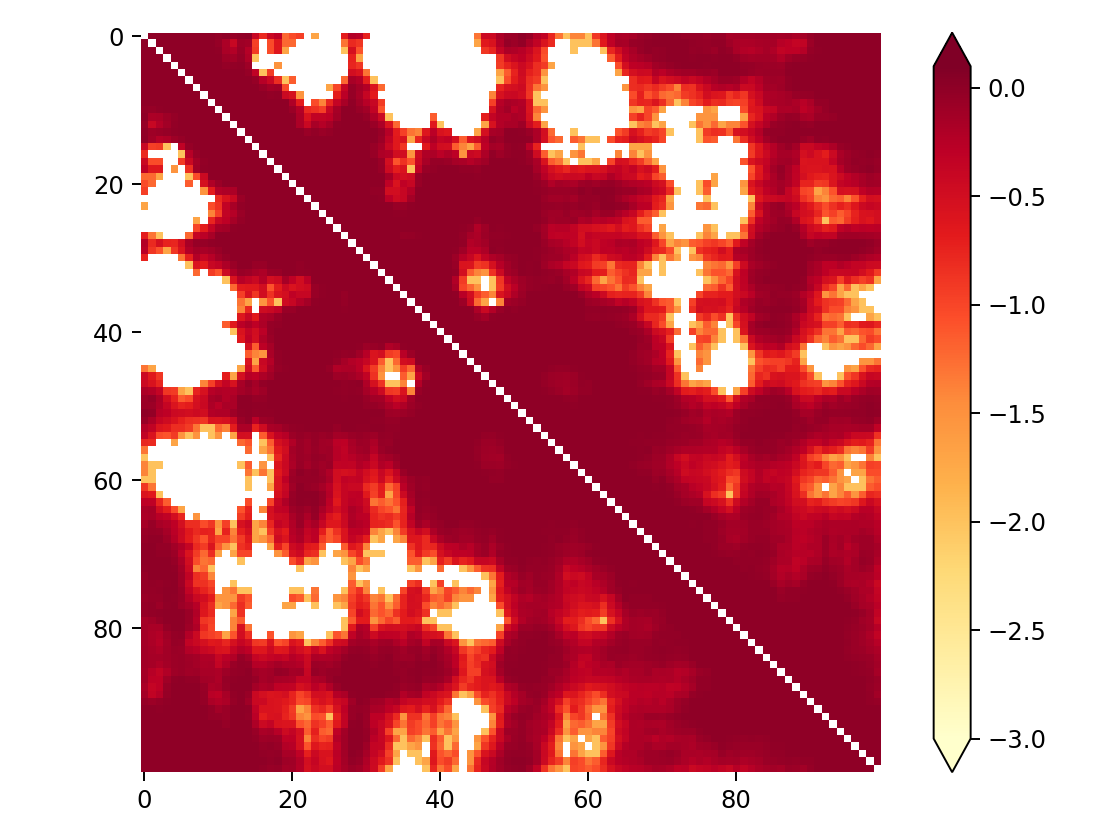

/home/dkannan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [64]:
fig, ax = plt.subplots()
heatmap = ax.imshow(np.log10(mat), cmap='YlOrRd', vmin=-3.0, vmax=0.1)
plt.colorbar(heatmap, extend="both")
fig.tight_layout()

<IPython.core.display.Javascript object>


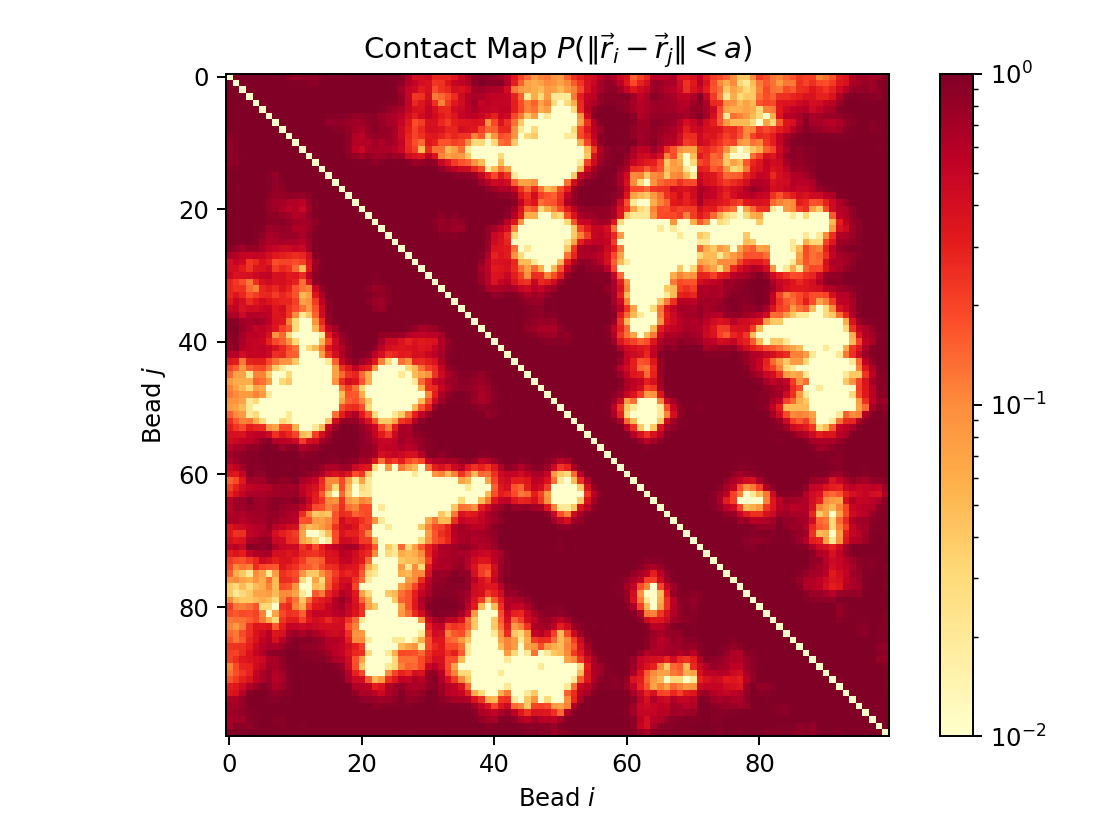

In [97]:
fig, ax = plt.subplots()
mat = contactmaps.monomerResolutionContactMap(filenames=uris[-100:], cutoff=5.0)
mat = mat / len(uris[-100:])
mat[mat == 0] = mat[mat > 0].min()
lognorm = LogNorm(vmin=mat.min(), vmax=mat.max())
im = ax.imshow(mat, norm=lognorm, cmap='YlOrRd')
fig.colorbar(im)
ax.set_title(r'Contact Map $P(\Vert \vec{r}_i - \vec{r}_j \Vert < a)$')
ax.set_xlabel(r'Bead $i$')
ax.set_ylabel(r'Bead $j$')
fig.tight_layout()

In [57]:
mat = mat / np.mean(np.diag(mat, k=1))
mat10 = np.log10(mat)
mat10.min()

/home/dkannan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


-inf